# Some stuff we need to do before the analysis

In [1]:
import geopandas as gpd
%matplotlib inline

## Creating neighborhoods file with Skid Row

We need to run calculations on neighborhoods as officially defined by The Times' [Mapping L.A.](http://maps.latimes.com/neighborhoods/) project. We'll use the neighborhoods of the city of Los Angeles with one exception: The addition of Skid Row, an unofficial microneighborhood of Downtown L.A., home to one of the biggest populations of homeless people in the city.

In [2]:
hoods = gpd.read_file("http://boundaries.latimes.com/1.0/boundary-set/la-county-neighborhoods-v5/?format=geojson")

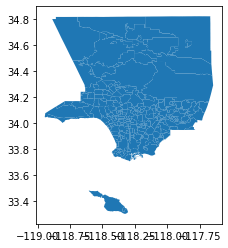

In [3]:
hoods.plot()

Filter down to L.A. city

In [4]:
lahoods = hoods.loc[
    hoods.metadata.map(dict).apply(lambda x: x['type'] == 'segment-of-a-city'),
    ['name','geometry']
]

In [5]:
len(lahoods)

114

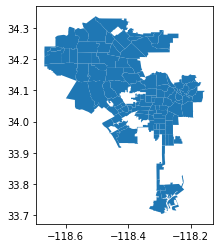

In [6]:
lahoods.plot()

This is drawn based on the Skid Row neighborhood council's boundaries.

In [7]:
skidrow = gpd.read_file('input/neighborhoods/skid-row.geojson')

In [8]:
skidrow.head()

,name,geometry
0,Skid Row,"(POLYGON ((-118.2381244 34.04325639999996, -11..."


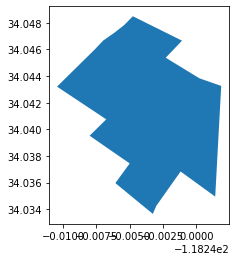

In [9]:
skidrow.plot()

Skid Row needs to be taken out of Downtown

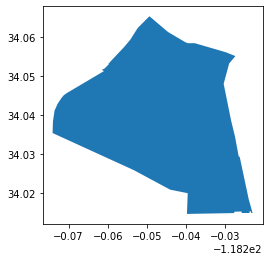

In [10]:
downtown = lahoods[lahoods.name == 'Downtown']
downtown.plot()

In [11]:
downtown

,name,geometry
60,Downtown,(POLYGON ((-118.2402070000001 34.0587109991238...


Difference calculation

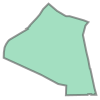

In [12]:
dtla = downtown.geometry.iloc[0]
dtla

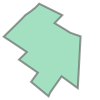

In [13]:
sr = skidrow.geometry.iloc[0]
sr

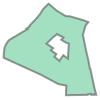

In [14]:
newdtla = dtla.difference(sr)
newdtla

Put it all back together in one GeoDataFrame

In [15]:
newlahoods = gpd.pd.concat([
    lahoods[lahoods.name != 'Downtown'],
    gpd.GeoDataFrame([
        {'name':'Downtown','geometry':newdtla},
        {'name':'Skid Row','geometry':sr},
    ])
])

Make sure this is exactly one more neighborhood than before

In [16]:
len(newlahoods)

115

In [17]:
newlahoods.head()

,name,geometry
1,Adams-Normandie,(POLYGON ((-118.3090080000001 34.0374109991240...
9,Arleta,(POLYGON ((-118.4220150000001 34.2241029991218...
10,Arlington Heights,"(POLYGON ((-118.315909 34.05261099912384, -118..."
13,Atwater Village,(POLYGON ((-118.2783247308968 34.1530071452962...
17,Baldwin Hills/Crenshaw,(POLYGON ((-118.3562610000001 34.0248359991243...


In [18]:
newlahoods.tail()

,name,geometry
269,Windsor Square,"(POLYGON ((-118.313709 34.07630999912366, -118..."
270,Winnetka,"(POLYGON ((-118.562213 34.23150299912167, -118..."
271,Woodland Hills,"(POLYGON ((-118.57569 34.18822399912241, -118...."
0,Downtown,POLYGON ((-118.2402070000001 34.05871099912385...
1,Skid Row,"(POLYGON ((-118.2381244 34.04325639999996, -11..."


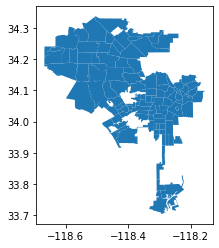

In [19]:
newlahoods.plot()

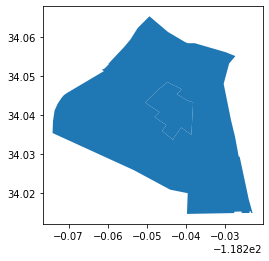

In [20]:
newlahoods[newlahoods.name.isin(['Downtown','Skid Row'])].plot()

In [21]:
newlahoods.to_file('input/neighborhoods/custom-la-hoods-skid-row.geojson', driver='GeoJSON')

Create a city boundary of L.A.

In [22]:
lacityboundary = newlahoods.copy()

In [23]:
lacityboundary['name'] = 'cityofla'

In [24]:
lacityboundary['geometry'] = lacityboundary['geometry'].buffer(0.0001)

In [25]:
lacityboundary = lacityboundary.dissolve('name')

In [26]:
lacityboundary.head()

,geometry
name,
cityofla,(POLYGON ((-118.2675810061726 33.7299711065925...


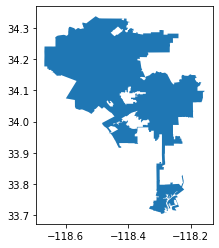

In [27]:
lacityboundary.plot()

In [28]:
lacityboundary.to_file('input/neighborhoods/la-city-boundary.geojson', driver='GeoJSON')

## Allocating census tracts to neighborhoods

To estimate the homeless population in each neighborhood, we need to take data from the Los Angeles County Homeless Services Authority (LAHSA). Their counts are collected at the census tract level, and because census tracts cross neighborhood boundaries (which are drawn around census blocks) we need to apportion the tracts into each neighborhood, based on how much area of each tract is in each neighborhood.

In [29]:
tracts = gpd.read_file("http://boundaries.latimes.com/1.0/boundary-set/census-tracts-2012/?format=geojson")

In [30]:
tracts.head()

,kind,external_id,name,slug,set,metadata,resource_uri,geometry
0,Census Tract (2012),06037101110,06037101110,06037101110-census-tract-2012,/1.0/boundary-set/census-tracts-2012/,"{'INTPTLAT': '+34.2594737', 'NAME': '1011.10',...",/1.0/boundary/06037101110-census-tract-2012/,"(POLYGON ((-118.302291 34.258697, -118.300787 ..."
1,Census Tract (2012),06037101122,06037101122,06037101122-census-tract-2012,/1.0/boundary-set/census-tracts-2012/,"{'INTPTLAT': '+34.2677213', 'NAME': '1011.22',...",/1.0/boundary/06037101122-census-tract-2012/,"(POLYGON ((-118.303334 34.273536, -118.303178 ..."
2,Census Tract (2012),06037101210,06037101210,06037101210-census-tract-2012,/1.0/boundary-set/census-tracts-2012/,"{'INTPTLAT': '+34.2529724', 'NAME': '1012.10',...",/1.0/boundary/06037101210-census-tract-2012/,"(POLYGON ((-118.299451 34.255978, -118.285924 ..."
3,Census Tract (2012),06037101220,06037101220,06037101220-census-tract-2012,/1.0/boundary-set/census-tracts-2012/,"{'INTPTLAT': '+34.2516085', 'NAME': '1012.20',...",/1.0/boundary/06037101220-census-tract-2012/,"(POLYGON ((-118.285924 34.248959, -118.285924 ..."
4,Census Tract (2012),06037101300,06037101300,06037101300-census-tract-2012,/1.0/boundary-set/census-tracts-2012/,"{'INTPTLAT': '+34.2487732', 'NAME': '1013', 'I...",/1.0/boundary/06037101300-census-tract-2012/,"(POLYGON ((-118.272473 34.232527, -118.271936 ..."


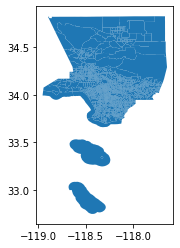

In [31]:
tracts.plot()

In [32]:
trimmed_tracts = tracts[[
    'name',
    'geometry'
]].rename(columns={"name": "tract"})

In [33]:
trimmed_tracts.head()

,tract,geometry
0,06037101110,"(POLYGON ((-118.302291 34.258697, -118.300787 ..."
1,06037101122,"(POLYGON ((-118.303334 34.273536, -118.303178 ..."
2,06037101210,"(POLYGON ((-118.299451 34.255978, -118.285924 ..."
3,06037101220,"(POLYGON ((-118.285924 34.248959, -118.285924 ..."
4,06037101300,"(POLYGON ((-118.272473 34.232527, -118.271936 ..."


First clip tracts against L.A. city hoods.

In [34]:
trimmed_tracts_lacity = gpd.overlay(trimmed_tracts, newlahoods, how='intersection').sort_values('tract')

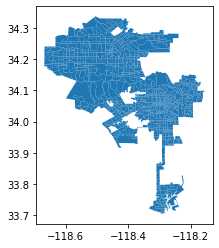

In [35]:
trimmed_tracts_lacity.plot()

In [36]:
len(trimmed_tracts_lacity)

2023

In [37]:
trimmed_tracts_lacity['area'] = trimmed_tracts_lacity['geometry'].area

In [38]:
trimmed_tracts_lacity.sort_values('tract').head()

,tract,name,geometry,area
0,06037101110,Tujunga,"POLYGON ((-118.302291 34.258697, -118.300787 3...",1.119492e-04
16,06037101122,Sunland,(POLYGON ((-118.2996861471204 34.2752842343742...,8.402370e-07
1,06037101122,Tujunga,POLYGON ((-118.3033104596139 34.27359937796265...,2.589085e-04
2,06037101210,Tujunga,"POLYGON ((-118.299451 34.255978, -118.285924 3...",6.348535e-05
3,06037101220,Tujunga,"POLYGON ((-118.285924 34.248959, -118.285924 3...",6.849204e-05


Calculate total area for each tract based on its original shape (pre-clipping)

In [39]:
trimmed_tracts['total_tract_area'] = trimmed_tracts['geometry'].area

In [40]:
trimmed_tracts.sort_values('tract').head()

,tract,geometry,total_tract_area
0,06037101110,"(POLYGON ((-118.302291 34.258697, -118.300787 ...",0.000112
1,06037101122,"(POLYGON ((-118.303334 34.273536, -118.303178 ...",0.000260
2,06037101210,"(POLYGON ((-118.299451 34.255978, -118.285924 ...",0.000063
3,06037101220,"(POLYGON ((-118.285924 34.248959, -118.285924 ...",0.000068
4,06037101300,"(POLYGON ((-118.272473 34.232527, -118.271936 ...",0.000252


In [41]:
calcs = trimmed_tracts_lacity.drop('geometry', axis=1)\
.merge(trimmed_tracts.drop('geometry', axis=1))\
.sort_values('tract')

In [42]:
calcs['tract_percent'] = calcs['area'] / calcs['total_tract_area']

In [43]:
calcs.head()

,tract,name,area,total_tract_area,tract_percent
0,06037101110,Tujunga,1.119492e-04,0.000112,1.000000
1,06037101122,Sunland,8.402370e-07,0.000260,0.003235
2,06037101122,Tujunga,2.589085e-04,0.000260,0.996765
3,06037101210,Tujunga,6.348535e-05,0.000063,1.000000
4,06037101220,Tujunga,6.849204e-05,0.000068,1.000000


In [44]:
len(calcs)

2023

In [45]:
calcs.drop(['area','total_tract_area'], axis=1)\
.to_csv('input/neighborhoods/tract-neighborhood-allocation.csv', index=False)